In [1]:
import nibabel as nib
import matplotlib.pyplot as plt
import numpy as np
import os 

In [2]:
ct_file = "/kaggle/input/left-knee/left_knee.nii"
mask_file = "/kaggle/input/left-knee/bone_segmentation_task1_1.nii"


In [ ]:
def visualize(image_data,name):
    # --- Choose slices to visualize ---
    num_slices = 9
    slice_indices = np.linspace(0, image_data.shape[2] - 1, num_slices, dtype=int)

    # --- Plot slices ---
    fig, axes = plt.subplots(3, 3, figsize=(10, 10))
    axes = axes.flatten()

    for i, slice_idx in enumerate(slice_indices):
        axes[i].imshow(image_data[:, :, slice_idx], cmap='gray')
        axes[i].set_title(f"Slice {slice_idx}")
        axes[i].axis('off')
    plt.savefig(name)
    plt.tight_layout()
    plt.show()

def load_nifti(file_path):
    """
    Load a NIfTI file and return the data array and affine.
    """
    nifti = nib.load(file_path)
    data = nifti.get_fdata()
    affine = nifti.affine
    return data, affine


def save_nifti(data, affine, output_path):
    """
    Save a NumPy array as a NIfTI file.
    """
    nifti = nib.Nifti1Image(data.astype(np.float32), affine)
    nib.save(nifti, output_path)

In [ ]:
image_data,_=load_nifti(ct_file)
visualize(image_data,'test')

In [ ]:
def segment_knee_regions(ct_path, mask_path, output_dir):
    """
    Segment Tibia, Femur, and Background from a CT volume using the mask.
    """
    # Load the CT scan and segmentation mask
    ct_data, ct_affine = load_nifti(ct_path)
    mask_data, _ = load_nifti(mask_path)

    # Define region labels (change if your mask uses different values)
    TIBIA_LABEL = 1
    FEMUR_LABEL = 2
    BACKGROUND_LABEL = 0

    # Generate binary masks
    tibia_mask = (mask_data == TIBIA_LABEL)
    femur_mask = (mask_data == FEMUR_LABEL)
    background_mask = (mask_data == BACKGROUND_LABEL)

    # Apply masks to CT data
    tibia_volume = ct_data * tibia_mask
    femur_volume = ct_data * femur_mask
    background_volume = ct_data * background_mask

    # Save each region as a new .nii.gz file
    os.makedirs(output_dir, exist_ok=True)
    save_nifti(tibia_volume, ct_affine, os.path.join(output_dir, "tibia_volume.nii.gz"))
    save_nifti(femur_volume, ct_affine, os.path.join(output_dir, "femur_volume.nii.gz"))
    save_nifti(background_volume, ct_affine, os.path.join(output_dir, "background_volume.nii.gz"))

    print("Segmentation done. Files saved to:", output_dir)


In [ ]:
segment_knee_regions(ct_file, mask_file, output_folder)

In [ ]:
def overlay_mask(image_slice, mask_slice, alpha=0.4, cmap_img='gray', cmap_mask='jet'):
    """
    Overlay a segmentation mask on a single image slice.
    
    Parameters:
    - image_slice: 2D numpy array of the image slice.
    - mask_slice: 2D numpy array of the mask slice (same size as image_slice).
    - alpha: float, transparency of the mask overlay.
    - cmap_img: str, colormap for the image.
    - cmap_mask: str, colormap for the mask.
    """
    plt.imshow(image_slice, cmap=cmap_img)
    if mask_slice is not None and np.any(mask_slice):
        plt.imshow(mask_slice, cmap=cmap_mask, alpha=alpha)
    plt.axis('off')

def visualize_nifti_with_mask(image_path, mask_path=None, num_slices=9, axis=2):
    """
    Visualize NIfTI image slices with optional mask overlays.
    
    Parameters:
    - image_path: str, path to the image .nii.gz file.
    - mask_path: str or None, path to the mask .nii.gz file (optional).
    - num_slices: int, number of slices to visualize.
    - axis: int, axis along which to slice (0=sagittal, 1=coronal, 2=axial).
    """
    # Load image and optional mask
    image, ct_affine = load_nifti(image_path)
    mask, _ = load_nifti(mask_path)
    assert mask is None or image.shape == mask.shape, "Image and mask must have the same shape"

    # Select slices evenly along the chosen axis
    slice_indices = np.linspace(0, image.shape[axis] - 1, num_slices, dtype=int)
    fig, axes = plt.subplots(3, 3, figsize=(10, 10))
    axes = axes.flatten()

    for i, idx in enumerate(slice_indices):
        ax = axes[i]
        plt.sca(ax)

        if axis == 0:
            img_slice = image[idx, :, :]
            msk_slice = mask[idx, :, :] if mask is not None else None
        elif axis == 1:
            img_slice = image[:, idx, :]
            msk_slice = mask[:, idx, :] if mask is not None else None
        else:  # default to axial
            img_slice = image[:, :, idx]
            msk_slice = mask[:, :, idx] if mask is not None else None

        overlay_mask(img_slice, msk_slice)
        ax.set_title(f"Slice {idx}")
    plt.savefig('slices with masks ')
    plt.tight_layout()
    plt.show()


In [ ]:
visualize_nifti_with_mask(
    ct_file,
    mask_file,  # Set to None if you don’t have a mask
    num_slices=9,
    axis=2  # axial view
)

In [ ]:
def plot_image_mask_overlay(image_path, mask_path, slice_index, axis=2, alpha=0.4):
    """
    Plot image slice, mask slice, and overlay side by side.

    Parameters:
    - image: 3D numpy array (CT volume)
    - mask: 3D numpy array (segmentation mask)
    - slice_index: int, index of the slice to visualize
    - axis: int, slicing axis (0=sagittal, 1=coronal, 2=axial)
    - alpha: float, transparency for overlay
    """
    image, ct_affine = load_nifti(image_path)
    mask, _ = load_nifti(mask_path)
    # Extract slices
    if axis == 0:
        img_slice = image[slice_index, :, :]
        mask_slice = mask[slice_index, :, :]
    elif axis == 1:
        img_slice = image[:, slice_index, :]
        mask_slice = mask[:, slice_index, :]
    else:
        img_slice = image[:, :, slice_index]
        mask_slice = mask[:, :, slice_index]

    # Plotting
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))

    axs[0].imshow(img_slice, cmap='gray')
    axs[0].set_title(f'Image Slice {slice_index}')
    axs[0].axis('off')

    axs[1].imshow(mask_slice, cmap='jet')
    axs[1].set_title(f'Mask Slice {slice_index}')
    axs[1].axis('off')

    axs[2].imshow(img_slice, cmap='gray')
    axs[2].imshow(mask_slice, cmap='jet', alpha=alpha)
    axs[2].set_title('Overlay')
    axs[2].axis('off')
    plt.savefig('slice_108_with_maska')
    plt.tight_layout()
    plt.show()

In [ ]:
slice_index = 108  
axis = 2  # Axial view

plot_image_mask_overlay(ct_file, mask_file, slice_index, axis=axis)

In [ ]:
pip install torch torchvision

In [10]:
import torch
import torch.nn as nn
import torchvision.models as models
import math

# --- Helper Functions for Inflation ---

def inflate_conv(conv2d, kernel_depth):
    """Inflates a Conv2d layer to a Conv3d layer by repeating weights."""
    if conv2d.in_channels % conv2d.groups != 0 or conv2d.out_channels % conv2d.groups != 0:
         raise ValueError("Inflating grouped convolutions is not straightforward with simple repetition.")

    # Get 2D parameters
    in_channels = conv2d.in_channels
    out_channels = conv2d.out_channels
    kernel_size_2d = conv2d.kernel_size
    stride_2d = conv2d.stride
    padding_2d = conv2d.padding
    dilation_2d = conv2d.dilation
    groups = conv2d.groups
    bias = conv2d.bias is not None

    # Create 3D convolution parameters
    # Temporal kernel size
    kernel_size_3d = (kernel_depth, kernel_size_2d[0], kernel_size_2d[1])
    
    # Typically stride 1 in time for simple inflation unless downsampling is desired
    # Based on the previous I3D code structure, transitions downsample spatially,
    # and the initial conv might downsample spatially. Temporal downsampling is handled
    # by the pooling layers in transition blocks.
    # So we'll use a temporal stride of 1 here for convolution inflation.
    stride_3d = (1, stride_2d[0], stride_2d[1])
    # Temporal padding to keep temporal dimension size
    padding_3d = (kernel_depth // 2, padding_2d[0], padding_2d[1])
    dilation_3d = (1, dilation_2d[0], dilation_2d[1]) # Dilation usually 1 in time

    # Create 3D Conv layer
    conv3d = nn.Conv3d(in_channels, out_channels, kernel_size_3d, stride_3d, padding_3d,
                       dilation=dilation_3d, groups=groups, bias=bias)

    # Inflate weights (replication and scaling)
    conv2d_weights = conv2d.weight.data #  Shape [out_channels, 3, H, W]
    #averaged_weights = conv2d_weights.mean(dim=1, keepdim=True) # Shape [out_channels, 1, H, W]

                 # Now repeat this 1-channel weight along the temporal dimension
    inflated_weights = conv2d_weights.unsqueeze(2).repeat(1, 1, kernel_depth, 1, 1)



    # Normalize by dividing by the depth (as per requirement ii)
    if kernel_depth > 0: # Avoid division by zero if somehow kernel_depth is 0
        inflated_weights = inflated_weights / kernel_depth

    # Copy inflated weights to the 3D Conv layer
    conv3d.weight.data.copy_(inflated_weights)

    # Copy bias if it exists
    if bias:
        conv3d.bias.data.copy_(conv2d.bias.data)

    return conv3d

def inflate_batch_norm(bn2d):
    """Inflates a BatchNorm2d layer to a BatchNorm3d layer."""
    bn3d = nn.BatchNorm3d(bn2d.num_features)
    # Copy parameters and running statistics
    bn3d.weight.data.copy_(bn2d.weight.data)
    bn3d.bias.data.copy_(bn2d.bias.data)
    bn3d.running_mean.copy_(bn2d.running_mean)
    bn3d.running_var.copy_(bn2d.running_var)
    # bn3d.num_batches_tracked.copy_(bn2d.num_batches_tracked) # Copy if your BN uses this
    return bn3d

def inflate_relu(relu2d):
    """Returns a ReLU layer (same for 2D and 3D)."""
    return nn.ReLU(inplace=relu2d.inplace)

def inflate_pool(pool2d, temporal_stride=1):
    """Inflates a Pooling layer to a 3D Pooling layer."""
    # Get 2D parameters
    kernel_size_2d = pool2d.kernel_size
    stride_2d = pool2d.stride
    padding_2d = pool2d.padding
    dilation_2d = pool2d.dilation if hasattr(pool2d, 'dilation') else 1 # MaxPool2d has dilation
    return_indices = pool2d.return_indices if hasattr(pool2d, 'return_indices') else False # MaxPool2d has this
    ceil_mode = pool2d.ceil_mode if hasattr(pool2d, 'ceil_mode') else False # Pool2d has this

    # Ensure kernel_size, stride, padding are tuples for consistency
    if not isinstance(kernel_size_2d, tuple): kernel_size_2d = (kernel_size_2d,) * 2
    if not isinstance(stride_2d, tuple): stride_2d = (stride_2d,) * 2
    if not isinstance(padding_2d, tuple): padding_2d = (padding_2d,) * 2
    if not isinstance(dilation_2d, tuple): dilation_2d = (dilation_2d,) * 2


    # Create 3D pooling parameters
    # Temporal kernel size (1 for no pooling in time by the pool layer itself, temporal_stride handles downsampling)
    kernel_size_3d = (1, kernel_size_2d[0], kernel_size_2d[1])
    # Temporal stride for downsampling
    stride_3d = (temporal_stride, stride_2d[0], stride_2d[1])
    # Temporal padding (0 as we don't pool over time)
    padding_3d = (0, padding_2d[0], padding_2d[1])
    dilation_3d = (1, dilation_2d[0], dilation_2d[1])

    if isinstance(pool2d, nn.MaxPool2d):
        return nn.MaxPool3d(kernel_size_3d, stride=stride_3d, padding=padding_3d,
                            dilation=dilation_3d, return_indices=return_indices, ceil_mode=ceil_mode)
    elif isinstance(pool2d, nn.AvgPool2d):
        # AvgPool2d also has count_include_pad attribute
        count_include_pad = pool2d.count_include_pad if hasattr(pool2d, 'count_include_pad') else True
        return nn.AvgPool3d(kernel_size_3d, stride=stride_3d, padding=padding_3d, ceil_mode=ceil_mode,
                            count_include_pad=count_include_pad) # Count include pad might need adjustment for 3D?
    else:
        raise ValueError(f"Unsupported pooling type: {type(pool2d)}")

# --- Inflated DenseNet Components ---

class InflatedDenseLayer(nn.Module):
    def __init__(self, dense_layer2d, conv_kernel_depth=3):
        super(InflatedDenseLayer, self).__init__()
        self.layers = nn.Sequential()
        for name, child in dense_layer2d.named_children():
            if isinstance(child, nn.BatchNorm2d):
                self.layers.add_module(name, inflate_batch_norm(child))
            elif isinstance(child, nn.ReLU):
                self.layers.add_module(name, inflate_relu(child))
            elif isinstance(child, nn.Conv2d):
                # For the bottleneck 1x1 conv, kernel_depth is 1
                # For the 3x3 conv, kernel_depth is user-specified (default 3)
                self.layers.add_module(name, inflate_conv(child, kernel_depth=child.kernel_size[0] if child.kernel_size != (1,1) else 1))

            else:
                raise ValueError(f"Unsupported layer type in DenseLayer: {type(child)}")
        # DenseLayer also has a drop_rate attribute
        self.drop_rate = dense_layer2d.drop_rate

    def forward(self, x):
        new_features = self.layers(x)
        if self.drop_rate > 0 and self.training: # Apply dropout only during training
            new_features = nn.functional.dropout(new_features, p=self.drop_rate, training=self.training)
        # DenseNet connectivity: concatenate input with new features
        return torch.cat([x, new_features], 1)

class InflatedTransition(nn.Module):
    def __init__(self, transition2d, temporal_pool_stride=2):
        super(InflatedTransition, self).__init__()
        self.layers = nn.Sequential()
        for name, child in transition2d.named_children():
            if isinstance(child, nn.BatchNorm2d):
                self.layers.add_module(name, inflate_batch_norm(child))
            elif isinstance(child, nn.ReLU):
                self.layers.add_module(name, inflate_relu(child))
            elif isinstance(child, nn.Conv2d): # This is the 1x1 convolution
                 self.layers.add_module(name, inflate_conv(child, kernel_depth=1))
            elif isinstance(child, nn.AvgPool2d): # This is the pooling layer for downsampling
                self.layers.add_module(name, inflate_pool(child, temporal_stride=temporal_pool_stride))
            else:
                raise ValueError(f"Unsupported layer type in Transition: {type(child)}")

    def forward(self, x):
        return self.layers(x)

# --- Main Inflation Function ---

def inflate_densenet121(densenet2d, frame_nb, conv_kernel_depth=3, temporal_pool_stride=2,input_channels=1):
    """
    Inflates a torchvision DenseNet121 model to a 3D model.

    Args:
        densenet2d (torchvision.models.densenet.DenseNet): The pre-trained 2D DenseNet121 model.
        frame_nb (int): The expected number of frames in the input video.
        conv_kernel_depth (int): The temporal kernel size to use for inflating 2D convs > 1x1.
                                 Default is 3 (3x3x3).
        temporal_pool_stride (int): The temporal stride to use for inflating spatial pooling
                                    layers in transition blocks. Default is 2.

    Returns:
        torch.nn.Module: The inflated 3D DenseNet model.
    """
    # Inflate the features part (contains initial conv, pool, dense blocks, transitions)
    features_3d = nn.Sequential()
    transition_nb = 0
    # Flag to identify the very first convolutional layer
    is_first_conv_layer = True
    for name, child in densenet2d.features.named_children():
        if isinstance(child, nn.Conv2d): # Initial Conv2d
            if is_first_conv_layer:
                 # --- SPECIAL HANDLING FOR THE VERY FIRST CONV LAYER ---
                 # The first Conv2d in DenseNet121 has in_channels=3.
                 # We need to change its in_channels to 'input_channels' (e.g., 1)
                 # and adapt its weights.

                 original_conv2d = child
                 original_in_channels = original_conv2d.in_channels # This is 3
                 if original_in_channels != 3:
                     # This inflation logic assumes the original model starts with 3 channels
                     warnings.warn(f"Expected first Conv2d to have 3 input channels, but got {original_in_channels}. Inflation logic might be incorrect.")

                 # Get original parameters except in_channels
                 out_channels = original_conv2d.out_channels
                 kernel_size_2d = original_conv2d.kernel_size
                 stride_2d = original_conv2d.stride
                 padding_2d = original_conv2d.padding
                 dilation_2d = original_conv2d.dilation
                 groups = original_conv2d.groups
                 bias = original_conv2d.bias is not None

                 # Create the new Conv3d with the DESIRED input_channels
                 # The temporal kernel size for the first layer is typically the spatial kernel size (7x7 -> 7x7x7)
                 kernel_depth_3d = kernel_size_2d[0] # Use spatial kernel size for time

                 kernel_size_3d = (kernel_depth_3d, kernel_size_2d[0], kernel_size_2d[1])
                 stride_3d = (1, stride_2d[0], stride_2d[1]) # Temporal stride 1
                 padding_3d = (kernel_depth_3d // 2, padding_2d[0], padding_2d[1])
                 dilation_3d = (1, dilation_2d[0], dilation_2d[1])

                 first_conv3d = nn.Conv3d(input_channels, out_channels, kernel_size_3d, stride_3d, padding_3d,
                                          dilation=dilation_3d, groups=groups, bias=bias)

                 # Inflate weights: Original weights shape [out_channels, 3, H, W]
                 original_weights = original_conv2d.weight.data

                 if input_channels == 1 and original_in_channels == 3:
                     # Average the original 3 input channel weights
                     adapted_weights_2d = original_weights.mean(dim=1, keepdim=True) # Shape [out_channels, 1, H, W]
                 elif input_channels == original_in_channels:
                     # Input channels match, just use original weights
                     adapted_weights_2d = original_weights
                 else:
                     # Handle other input channel numbers if needed (e.g., randomly initialize new weights)
                     warnings.warn(f"Handling inflation from {original_in_channels} to {input_channels} channels. "
                                   "Using averaged weights if original=3, otherwise weights might need custom handling.")
                     if original_in_channels == 3:
                         adapted_weights_2d = original_weights.mean(dim=1, keepdim=True).repeat(1, input_channels, 1, 1) # Repeat averaged weight
                     else:
                         # Fallback: Random initialization for the new layer if sizes don't match
                         print(f"Initializing weights for first Conv3d ({original_in_channels} -> {input_channels}) randomly.")
                         # The first_conv3d layer is already initialized randomly by default, so nothing more to do here.
                         # We can just skip the weight copying step.
                         adapted_weights_2d = None # Indicate no specific weights to copy


                 if adapted_weights_2d is not None:
                    # Repeat the adapted 2D weights along the temporal dimension
                    # Shape [out_channels, input_channels, 1, H, W] -> [out_channels, input_channels, D, H, W]
                    inflated_weights = adapted_weights_2d.unsqueeze(2).repeat(1, 1, kernel_depth_3d, 1, 1)

                    # Normalize by dividing by the depth
                    if kernel_depth_3d > 0:
                         inflated_weights = inflated_weights / kernel_depth_3d

                    # Copy inflated weights to the new Conv3d
                    first_conv3d.weight.data.copy_(inflated_weights)

                 if bias:
                     first_conv3d.bias.data.copy_(original_conv2d.bias.data)

                 features_3d.add_module(name, first_conv3d)
                 is_first_conv_layer = False # Mark that the first conv is processed

            else:
                 # --- STANDARD INFLATION FOR SUBSEQUENT CONV LAYERS ---
                 # These layers should use the standard inflate_conv logic
                 # Their in_channels will match the out_channels of the preceding 3D layer.
                 # We still need to handle the kernel depth for non-1x1 convs.
                 temporal_k_depth = child.kernel_size[0] if child.kernel_size != (1,1) else 1
                 features_3d.add_module(name, inflate_conv_standard(child, kernel_depth=temporal_k_depth))

             # The initial convolution in DenseNet121 is 7x7. Inflate it.
            
        elif isinstance(child, nn.BatchNorm2d): # Initial BatchNorm
             features_3d.add_module(name, inflate_batch_norm(child))
        elif isinstance(child, nn.ReLU): # Initial ReLU
             features_3d.add_module(name, inflate_relu(child))
        elif isinstance(child, nn.MaxPool2d): # Initial MaxPooling
             # Initial pool typically reduces spatial dimensions but not temporal
             # We'll make the temporal stride 1 here
             features_3d.add_module(name, inflate_pool(child, temporal_stride=1))
        elif isinstance(child, models.densenet._DenseBlock):
             # Inflate the DenseBlock
             block_3d = nn.Sequential()
             for nested_name, nested_child in child.named_children():
                 # Each child in a DenseBlock is a DenseLayer
                 assert isinstance(nested_child, models.densenet._DenseLayer)
                 block_3d.add_module(nested_name, InflatedDenseLayer(nested_child, conv_kernel_depth=conv_kernel_depth))
             features_3d.add_module(name, block_3d)
        elif isinstance(child, models.densenet._Transition):
             # Inflate the Transition layer
             features_3d.add_module(name, InflatedTransition(child, temporal_pool_stride=temporal_pool_stride))
             transition_nb += 1
        else:
            # print(f"Warning: Skipping unhandled layer type in features: {name} ({type(child)})")
            pass # Skip layers like OrderedDictWrapper if they appear

    # Calculate the final temporal dimension
    # Assumes each transition block reduces temporal dimension by temporal_pool_stride
    temporal_reduction_factor = int(math.pow(temporal_pool_stride, transition_nb))
    final_time_dim = frame_nb // temporal_reduction_factor
    if frame_nb % temporal_reduction_factor != 0:
         warnings.warn(f"Input frame_nb ({frame_nb}) is not perfectly divisible by temporal reduction factor ({temporal_reduction_factor}). "
                       "Final temporal dimension will be floor division result.")


    # Inflate the classifier part
    classifier_3d = nn.Sequential()
    for name, child in densenet2d.classifier.named_children():
        if isinstance(child, nn.Linear):
            # The linear layer input size needs to account for the flattened 3D features
            # It's final_time_dim * original_classifier_in_features
            original_in_features = child.in_features
            inflated_in_features = final_time_dim * original_in_features

            # Create new 3D linear layer
            linear3d = nn.Linear(inflated_in_features, child.out_features, bias=child.bias is not None)

            # Inflate weights
            linear2d_weights = child.weight.data # Shape [out_features, in_features_2d]

            # Reshape 2D weights to [out_features, in_features_2d, 1] (add a temporal dimension)
            inflated_weights = linear2d_weights.unsqueeze(2)
            # Repeat along the new temporal dimension
            inflated_weights = inflated_weights.repeat(1, 1, final_time_dim)
            # Reshape to match the 3D linear layer's expected shape [out_features, inflated_in_features]
            inflated_weights = inflated_weights.view(child.out_features, inflated_in_features)

            linear3d.weight.data.copy_(inflated_weights)

            # Copy bias if it exists
            if child.bias is not None: 
                linear3d.bias.data.copy_(child.bias.data)

            classifier_3d.add_module(name, linear3d)

        else:
            # print(f"Warning: Skipping unhandled layer type in classifier: {name} ({type(child)})")
            pass # DenseNet's classifier is typically just a Linear layer



    class InflatedDenseNetModel(nn.Module):
        def __init__(self, features_3d, classifier_3d, final_time_dim, final_layer_nb):
            super().__init__()
            self.features = features_3d
            self.classifier = classifier_3d
            self.final_time_dim = final_time_dim
            self.final_layer_nb = final_layer_nb # This is the number of channels before global pooling

        def forward(self, x):
            x = self.features(x)
            # Apply ReLU after features (matches typical DenseNet flow before classification)
            x = nn.functional.relu(x)
            # Global spatial average pooling. Kernel size matches expected output spatial dims.
            # Assuming 7x7 spatial dims before classification for DenseNet121 on ImageNet size inputs
            spatial_kernel_h = x.shape[-2]
            spatial_kernel_w = x.shape[-1]
            x = nn.functional.avg_pool3d(x, kernel_size=(1, spatial_kernel_h, spatial_kernel_w))
            # Flatten for classifier
            # Original shape: [batch, channels, depth, 1, 1] after spatial pooling
            # Permute to [batch, depth, channels, 1, 1]
            x = x.permute(0, 2, 1, 3, 4).contiguous()
            # View to [batch, depth * channels]
            #x = x.view(-1, self.final_time_dim * self.final_layer_nb)
            x = x.view(x.size(0), -1)  # [B, N]

            # Pass through classifier
            x = self.classifier(x)
            return x

    # Get the number of channels before the original 2D classifier
    final_layer_nb = densenet2d.classifier.in_features

    return InflatedDenseNetModel(features_3d, classifier_3d, final_time_dim, final_layer_nb)


# --- Testing the Inflation ---

import warnings

# a. Take a 2D pretrained DenseNet121 model
model_2d = models.densenet121(pretrained=True)
print("Loaded 2D DenseNet121 model.")


input_frame_nb = 512
# Temporal kernel depth for inflating 3x3 convs
conv_k_depth = 3
# Temporal stride for pooling in transition blocks
pool_t_stride = 2

# Inflate the model
i3d_densenet_model = inflate_densenet121(
    model_2d,
    frame_nb=input_frame_nb,
    conv_kernel_depth=conv_k_depth,
    temporal_pool_stride=pool_t_stride
)

print(f"\nInflated 3D DenseNet model created for {input_frame_nb} frames.")
# Print the structure of the inflated model (optional, can be long)
# print(i3d_densenet_model)

Loaded 2D DenseNet121 model.

Inflated 3D DenseNet model created for 512 frames.


In [4]:
# Create a dummy 3D input tensor
# Shape: [batch_size, channels, depth, height, width]
batch_size = 2
channels = 1
input_height = 224
input_width = 224

dummy_input_3d = torch.randn(batch_size, channels, input_frame_nb, input_height, input_width)
print("\nDummy input shape:", dummy_input_3d.shape)


# Perform a forward pass with the dummy input
try:
    i3d_densenet_model.eval() # Set model to evaluation mode (disables dropout, uses running stats for BN)
    with torch.no_grad(): # Disable gradient calculation for inference
        output = i3d_densenet_model(dummy_input_3d)

    print("\nForward pass successful!")
    print("Output shape:", output.shape)
    # The output shape should be [batch_size, num_classes]
    # For DenseNet121 pre-trained on ImageNet, num_classes is 1000
    print("Expected output shape:", (batch_size, 1000))

except Exception as e:
    print(f"\nForward pass failed: {e}")


Dummy input shape: torch.Size([2, 1, 512, 224, 224])

Forward pass successful!
Output shape: torch.Size([2, 65536])
Expected output shape: (2, 1000)


## Task3

In [11]:
import torch
import torch.nn.functional as F
import torch.nn as nn

def global_avg_pool_3d(x):
    return F.adaptive_avg_pool3d(x, 1).view(x.size(0), -1)

def extract_region_features(model_3d, volume_dict):
    """
    Extract features from 3 layers for each region in a 3D CT scan.

    Args:
        model_3d: Inflated DenseNet121 model (Conv3D based).
        volume_dict: Dict with keys 'Tibia', 'Femur', 'Background', each with a 3D volume tensor [1, C, D, H, W].

    Returns:
        Dictionary:
        {
            "Tibia": {"fifth_last": ..., "third_last": ..., "last": ...},
            "Femur": {...},
            "Background": {...}
        }
    """
    model_3d.eval()
    output_dict = {}

    # Prepare hooks
    feature_maps = {}
    def make_hook(name):
        def hook(module, input, output):
            feature_maps[name] = output
        return hook

    # Register hooks for the 3 layers
    hooks = []
    hooks.append(model_3d.features.denseblock2.register_forward_hook(make_hook('fifth_last')))
    hooks.append(model_3d.features.denseblock3.register_forward_hook(make_hook('third_last')))
    hooks.append(model_3d.features.denseblock4.register_forward_hook(make_hook('last')))

    # Process each region separately
    with torch.no_grad():
        for region_name, volume in volume_dict.items():
            feature_maps.clear()
            _ = model_3d(volume)  # Forward pass
            output_dict[region_name] = {
                name: global_avg_pool_3d(feat) for name, feat in feature_maps.items()
            }

    # Remove hooks
    for h in hooks:
        h.remove()

    return output_dict


In [12]:
import nibabel as nib
import torch

def prepare_volumes( tibia_mask,femur_mask,background_mask):
    
    tibia_volume=load_nifti_to_tensor(tibia_mask)
    femur_volume=load_nifti_to_tensor(femur_mask)
    background_volume=load_nifti_to_tensor(background_mask)
    
    tibia_volume=tibia_volume.unsqueeze(0).unsqueeze(0)
    femur_volume=femur_volume.unsqueeze(0).unsqueeze(0)
    background_volume=background_volume.unsqueeze(0).unsqueeze(0)
    
    return {
        "Tibia": tibia_volume,
        "Femur": femur_volume,
        "Background": background_volume,
    }

def load_nifti_to_tensor(path):
    """
    Load .nii or .nii.gz file into a PyTorch tensor of shape [D, H, W]
    """
    img = nib.load(path)
    data = img.get_fdata()  # Returns NumPy array, shape: [D, H, W] or [H, W, D]
    data = torch.tensor(data).permute(2, 0, 1)  # Rearrange to [D, H, W]
    return data.float()


tibia_mask_path='/kaggle/input/segmented-regions/tibia.nii'
femur_mask_path='/kaggle/input/segmented-regions/femur.nii'
background_mask_path='/kaggle/input/segmented-regions/background.nii'

# Example input: [1, 3, 16, 128, 128] tensors for each region
volume_dict = prepare_volumes(tibia_mask_path,femur_mask_path,background_mask_path)

features = extract_region_features(i3d_densenet_model, volume_dict)

# Print feature dimensions
for region, feats in features.items():
    print(f"\n{region} Features:")
    for layer, vec in feats.items():
        print(f"  {layer}: {vec.shape}")



Tibia Features:
  fifth_last: torch.Size([1, 512])
  third_last: torch.Size([1, 1024])
  last: torch.Size([1, 1024])

Femur Features:
  fifth_last: torch.Size([1, 512])
  third_last: torch.Size([1, 1024])
  last: torch.Size([1, 1024])

Background Features:
  fifth_last: torch.Size([1, 512])
  third_last: torch.Size([1, 1024])
  last: torch.Size([1, 1024])


In [19]:
import torch
import torch.nn.functional as F
import pandas as pd

# Assume this is already defined
# features = {...}

regions = ['Tibia', 'Femur', 'Background']
layers = ['fifth_last', 'third_last', 'last']

# All pairs of regions
region_pairs = [
    ('Tibia', 'Femur'),
    ('Tibia', 'Background'),
    ('Femur', 'Background')
]

# Dictionary to store results
results = {}

for layer in layers:
    for r1, r2 in region_pairs:
        v1 = features[r1][layer]
        v2 = features[r2][layer]
        
        # Flatten if needed
        v1 = v1.view(-1)
        v2 = v2.view(-1)
        
        # Compute cosine similarity
        similarity = F.cosine_similarity(v1, v2, dim=0).item()
        
        # Key format: "tibia_femur_last"
        key = f"{r1}_{r2}_{layer}"
        results[key] = similarity

# Convert to DataFrame (1 row, many columns)
df = pd.DataFrame([results])
df.to_csv("region_cosine_similarities.csv", index=False)

print(" Cosine similarity saved to region_cosine_similarities.csv")


 Cosine similarity saved to region_cosine_similarities.csv


In [26]:
import torch
import matplotlib.pyplot as plt
import numpy as np

import torch.nn as nn
import torch.nn.functional as F

class DenseNet3DFeatureExtractor(nn.Module):
    def __init__(self, model_3d):
        super().__init__()
        self.model = model_3d

    def forward(self, x):
        fmap = {}
        
        x = self.model.features.conv0(x)
        x = self.model.features.norm0(x)
        x = self.model.features.relu0(x)
        x = self.model.features.pool0(x)

        x = self.model.features.denseblock1(x)
        x = self.model.features.transition1(x)
        fmap['fifth_last'] = x.clone()

        x = self.model.features.denseblock2(x)
        x = self.model.features.transition2(x)
        fmap['third_last'] = x.clone()

        x = self.model.features.denseblock3(x)
        x = self.model.features.transition3(x)
        fmap['last'] = x.clone()

        return fmap  # Return full spatial feature maps
# Suppose you already have an input volume `x` with shape [1, C, D, H, W]
x=volume_dict['Tibia']

#x = x.to(device)

# Wrap your model
wrapped_model = DenseNet3DFeatureExtractor(i3d_densenet_model)
wrapped_model.eval()

with torch.no_grad():
    feature_maps = wrapped_model(x)

# Now feature_maps['last'], ['third_last'], etc. are 5D: [1, C, D, H, W]



ValueError: not enough values to unpack (expected 4, got 1)

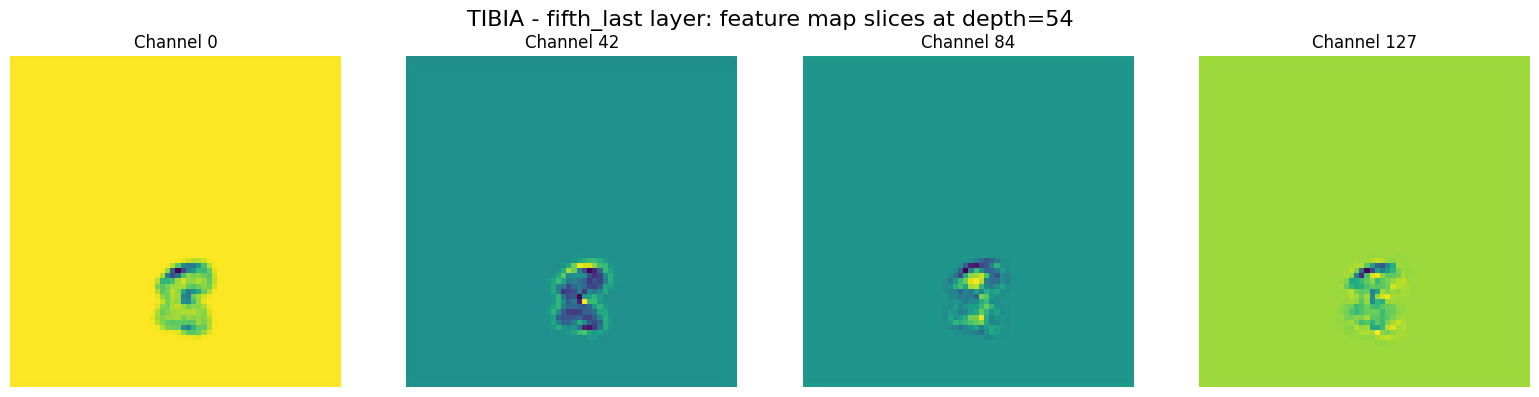

In [31]:
def normalize_tensor(t):
    t = t - t.min()
    t = t / (t.max() + 1e-8)
    return t
def show_feature_map_slices(feature_tensor, region="tibia", layer="last", num_channels=4):
    # feature_tensor: [1, C, D, H, W]
    feature_tensor = feature_tensor.squeeze(0).detach().cpu()  # -> [C, D, H, W]
    
    C, D, H, W = feature_tensor.shape
    mid_depth = D // 2
    selected_channels = np.linspace(0, C-1, num_channels, dtype=int)
    
    fig, axes = plt.subplots(1, num_channels, figsize=(4 * num_channels, 4))
    fig.suptitle(f"{region.upper()} - {layer} layer: feature map slices at depth={mid_depth}", fontsize=16)

    for i, ch in enumerate(selected_channels):
        fmap = feature_tensor[ch, mid_depth, :, :]  # Slice at middle depth
        fmap = normalize_tensor(fmap)
        axes[i].imshow(fmap, cmap='viridis')
        axes[i].set_title(f"Channel {ch}")
        axes[i].axis('off')

    plt.tight_layout()
    plt.savefig('Feature_maps_fifth_last_tibia')
    plt.show()
show_feature_map_slices(feature_maps['fifth_last'], region='tibia', layer='fifth_last')

In [ ]:
index_